## Student Information

Please enter the names and IDs of the two students below:

1. **Name**: Peter Atef  
   **ID**: `9202395`

2. **Name**: Beshoy Morad  
   **ID**: `9202405`


## Students Instructions

This is your first graded lab assignment, as you put the work you have studied in the lectures in action, please take this opportunity to enhance your understanding of the concepts and hone your skills. As you work on your assignment, please keep the following instructions in mind:

- Clearly state your personal information where indicated.
- Be ready with your work before the time of the next discussion slot in the schedule.
- Plagiarism will be met with penalties, refrain from copying any answers to make the most out of the assignment. If any signs of plagiarism are detected, actions will be taken.
- It is acceptable to share the workload of the assignment bearing the discussion in mind.
- Feel free to reach out if there were any ambiguities.


## Installation Instructions

When setting up your development environment for geospatial analysis, it's crucial to install the necessary libraries correctly to avoid common issues. Here are the steps and important notes to guide you through the installation process:

1. Install GDAL
   To avoid errors related to Visual Studio build files when installing GDAL via pip, it's recommended to use Conda. This method simplifies the installation process by handling binary dependencies:

```bash
conda install -c conda-forge gdal
```

1. Install EarthPy
   To circumvent dependency errors that might occur when installing EarthPy with Conda, use pip. This ensures that EarthPy and its Python dependencies are installed correctly:

```bash
pip install earthpy
```

1. Pay Attention to Versioning
   It's critical to select a Python version that satisfies the requirements of both GDAL, as it relates to GIS, and EarthPy. Ensuring compatibility across these libraries will prevent version conflicts and runtime errors.

1. Create a Python Environment
   To avoid disrupting your base environment or the default Python distribution, create a dedicated Python or Conda environment with Python versions 3.8, 3.9, or 3.10. This isolation helps manage dependencies more effectively and keeps your system tidy:

```bash
# For Conda
conda create -n geospatial python=3.8
conda activate geospatial

# Alternatively, for Python's venv
python -m venv geospatial
# Activate the environment as per your OS instructions
```

By following these instructions, you can set up a robust geospatial analysis environment that minimizes common installation issues and fosters a productive development workflow.

```

```


# Image Correction and Transformation


In [22]:
##Import all needed libraries
import numpy as np
from sklearn import cluster
from osgeo import gdal, gdal_array
import matplotlib.pyplot as plt
import earthpy.plot as ep
import earthpy.spatial as es
import cv2
import rasterio


## Bad Pixels


Numerous factors, including sensor disturbances, errors during data transmission, or potential equipment failures, can lead to the presence of erroneous pixels within satellite images. Such imperfections may compromise image integrity, thereby impacting the reliability of any subsequent analyses or interpretations derived from these images.


An effective strategy for addressing random bad pixels (values set to 0) involves utilizing an algorithm that identifies and substitutes these pixels with values reflective of their immediate surroundings. The steps for implementing this algorithm are outlined below:

1. **Detect Bad Pixels**: Start by pinpointing the bad pixels within the image. This identification can be achieved through methods like visual inspection or the use of automated detection algorithms.

2. **Establish a Neighborhood**: For each identified bad pixel, define a surrounding area or neighborhood. The extent of this neighborhood is determined by the image's characteristics and the bad pixel's impact.

3. **Compute Statistical Properties**: Analyze the statistical attributes, such as the mean, of the neighborhood's pixels.

4. **Substitute Bad Pixels**: Use the statistical measure obtained in the previous step to replace the value of the bad pixel. Techniques for this substitution may include interpolation, spatial filtering, or employing regression analysis.

5. **Iterate for Each Bad Pixel**: Execute the aforementioned steps (2-4) for every bad pixel detected in the image.


## Q1- Implement Random Bad Pixel Removal Algorithm

Shot noise is identified and repaired using the following methodology:

- **Identify Bad Pixels**: Begin by locating each bad pixel within the band $k$. Employ a straightforward thresholding algorithm that scans through the dataset. This process identifies and marks any pixel $BV_{i,j,k}$
  that exhibits a brightness value of zero, provided that the adjacent pixels exhibit non-zero values.

- **Evaluate Corrected Pixel Value**: After pinpointing the bad pixels, assess the appropriate value for correction by examining the eight surrounding pixels. This evaluation helps in determining a suitable replacement value that harmonizes with the pixel's immediate neighborhood.

### Requirements

A file that contains information for each band should display the following:

1. Indices of bad pixels
2. Corrected values
3. Total L1 Loss for the image after correction using the original image


In [23]:
# check rasterio library ;)
# Read in raster image 'RBN_Forest_27.tif' for the corrupt image
# Original image is 'Forest_27.tif'

def get_neighborhood(image, pixel):
	"""
	Function used to get the 8 neighborhood around the given pixel

	Args:
		image: The image to get the neighborhood from
		pixel: The pixel to get the neighborhood around
	"""
	# Define the neighborhood around the given pixel
	band_idx, row_idx, col_idx = pixel

	neighborhood = image[band_idx, max(row_idx - 1, 0):min(row_idx + 2, image.shape[1]),
							max(col_idx - 1, 0):min(col_idx + 2, image.shape[2])]

	return neighborhood

def is_bad_pixel(neighborhood, threshold = 3):
	"""
	Function used to check if the pixel is a bad pixel or not

	Args:
		neighborhood: The neighborhood around the given pixel
		threshold: The threshold used to check if the pixel is a bad pixel or not (number of zeros allowed in the neighborhood)
	"""
    
	# Check if there are too many zero values in the neighborhood
	if np.sum(neighborhood == 0) > threshold:
		return False
	else:
		return True

def detect_bad_pixels(images):
	"""
	Function used to detect bad pixels in the images

	Args:
		images: The images to detect the bad pixels in
	"""
	bad_pixels = []
	for band_idx, image in enumerate(images):
		# Detect bad pixels by checking if the pixel value is 0
		zero_indices = np.argwhere(image == 0)

		# Define the neighborhood around the given pixel
		pixels_neighborhood = [get_neighborhood(images, (band_idx, pixel[0], pixel[1])) for pixel in zero_indices]
		
		# Check if the pixel is bad pixel or not using a certain threshold (3)
		bad_pixels += [(band_idx, pixel[0], pixel[1], neighborhood) for pixel, neighborhood in zip(zero_indices, pixels_neighborhood) if is_bad_pixel(neighborhood)]

	return bad_pixels

def substitute_bad_pixels_median(images, bad_pixels):
    """
    Function used to replace bad pixels with the median value of the neighborhood

	Args:
		images: The images to replace the bad pixels in
		bad_pixels: The bad pixels to replace
    """
    corrected_images = np.copy(images)
    corrected_values = []
    
    for pixel in bad_pixels:
        band_idx, row_idx, col_idx, neighborhood = pixel
        
        # Compute statistical properties (median) of the neighborhood
        median_value = np.median(neighborhood)
        
        # Replace bad pixel with mean value for the corresponding band
        corrected_images[band_idx, row_idx, col_idx] = median_value
        corrected_values.append((band_idx, row_idx, col_idx, median_value))
    
    return corrected_images, corrected_values

def substitute_bad_pixels_mean(images, bad_pixels):
    """
    Function used to replace bad pixels with the mean value of the neighborhood

	Args:
		images: The images to replace the bad pixels in
		bad_pixels: The bad pixels to replace
    """
    corrected_images = np.copy(images)
    corrected_values = []
    
    for pixel in bad_pixels:
        band_idx, row_idx, col_idx, neighborhood = pixel
        
        # Compute statistical properties (mean) of the neighborhood
        mean_value = np.mean(neighborhood)
        
        # Replace bad pixel with mean value for the corresponding band
        corrected_images[band_idx, row_idx, col_idx] = mean_value
        corrected_values.append((band_idx, row_idx, col_idx, mean_value))
    
    return corrected_images, corrected_values

def compute_total_L1_loss(original_images, corrected_images):
    """
    Function used to compute the total L1 loss between original and corrected images
    
	Args:
		original_images: The original images
		corrected_images: The corrected images
    """
    # Compute the total L1 loss between original and corrected images
    l1_loss = np.sum(np.abs(original_images - corrected_images))
    return l1_loss

# Read in the original and corrupt images
with rasterio.open('Forest_27.tif') as original_ds, rasterio.open('RBN_Forest_27.tif') as corrupt_ds:
	# Read all 13 bands
	original_images = original_ds.read()
	corrupt_images = corrupt_ds.read()

	# Detect bad pixels for each band
	bad_pixels = detect_bad_pixels(corrupt_images)

	# Replace bad pixels for each band
	# Median filtering
	corrected_images_median, corrected_values_median = substitute_bad_pixels_median(corrupt_images, bad_pixels)

	# Mean
	corrected_images_mean, corrected_values_mean = substitute_bad_pixels_mean(corrupt_images, bad_pixels)


	# Compute total L1 loss for each method
	l1_loss_median = compute_total_L1_loss(original_images, corrected_images_median)
	l1_loss_mean = compute_total_L1_loss(original_images, corrected_images_mean)


	# Save information to files
	with open('correction_info_median.txt', 'w') as f:
		f.write("Band\tPixel Row\tPixel Column\tCorrected Value\n")
		for entry in corrected_values_median:
			f.write(f"{entry[0]}\t{entry[1]}\t{entry[2]}\t{entry[3]}\n")
		f.write(f"Total L1 Loss: {l1_loss_median}\n")

	with open('correction_info_mean.txt', 'w') as f:
		f.write("Band\tPixel Row\tPixel Column\tCorrected Value\n")
		for entry in corrected_values_mean:
			f.write(f"{entry[0]}\t{entry[1]}\t{entry[2]}\t{entry[3]}\n")
		f.write(f"Total L1 Loss: {l1_loss_mean}\n")

# Choose the best approach based on L1 loss
best_approach = min((l1_loss_median, 'Median Filtering'), (l1_loss_mean, 'Mean Filtering'))

print("Best Approach:", best_approach[1])
print("Total L1 Loss:", best_approach[0])

Best Approach: Mean Filtering
Total L1 Loss: 67728


Several algorithms, including median filtering, nearest neighbor interpolation, and wavelet-based denoising, address random bad pixels in satellite imagery. The selection depends on the image characteristics and analysis needs. However, these methods may introduce smoothing or blurring, potentially impacting the precision of certain analyses.


## Atmospheric Errors

Satellite imagery is often affected by atmospheric interactions, notably **scattering** and **absorption** by atmospheric particles. These phenomena can obscure image details and introduce absorption lines from gases like water vapor, impacting the accuracy of interpretations.

To counteract these effects, techniques such as **Haze Removal by Dark Subtraction** (Dark Object Subtraction) are employed. These methods adjust imagery based on the specific atmospheric conditions affecting each image, ensuring more reliable data for analysis.


## Q2- Implement Haze Removal by Dark Subtraction

Haze Removal by Dark Subtraction is a process designed to correct for atmospheric effects that add a constant level of brightness across all pixels in each spectral band of an image. The steps for implementing this method are as follows:

1. **Assumption**: The process begins with the assumption that in a haze-free image, some pixels in each band should have brightness values close to zero. However, haze adds a constant brightness to all pixels.

2. **Histogram Analysis**: Histograms of the spectral bands are analyzed. Normally, the lowest significant brightness values should be near zero, but haze shifts these values away from the origin. This shift is more pronounced for shorter wavelengths.

3. **Histogram Shift**: The histograms are adjusted by shifting them to the left, making the minimum significant brightness values approach zero. This adjustment reduces the impact of atmospheric scattering.

4. **Subtractive Bias Calculation**: A subtractive bias is determined for each spectral band based on the minimum brightness value (BV) observed in the histograms. This bias represents the haze effect to be removed.

5. **Bias Application**: $$BV_{i,j,k} = BV_{i,j,k} - BV_{bias}$$

By applying these biases, the haze effect is minimized, resulting in clearer and more accurate images.

### Requirements

i. A figure that contains information for each band should display the following:

1. Histograms side by side before and after haze removal.
2. Images side by side (grayscale).
3. Threshold should be displayed in the image as a caption. see plt.figtext

ii. A final figure that has the two images before and after haze removal side by side.


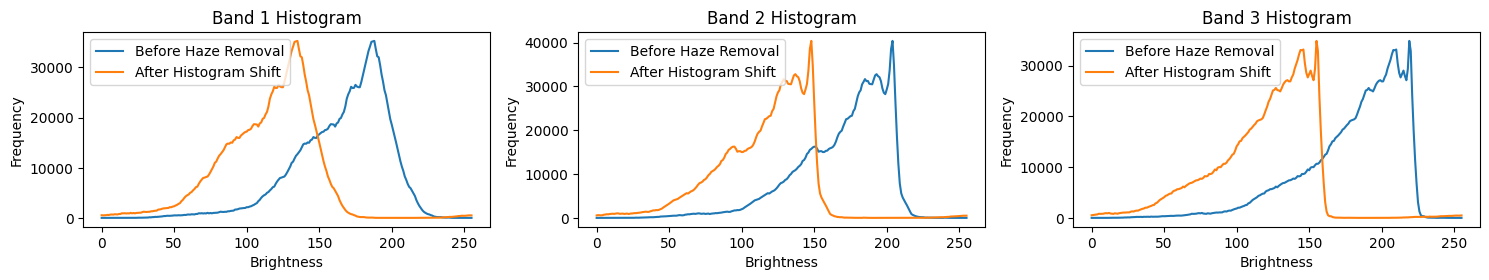

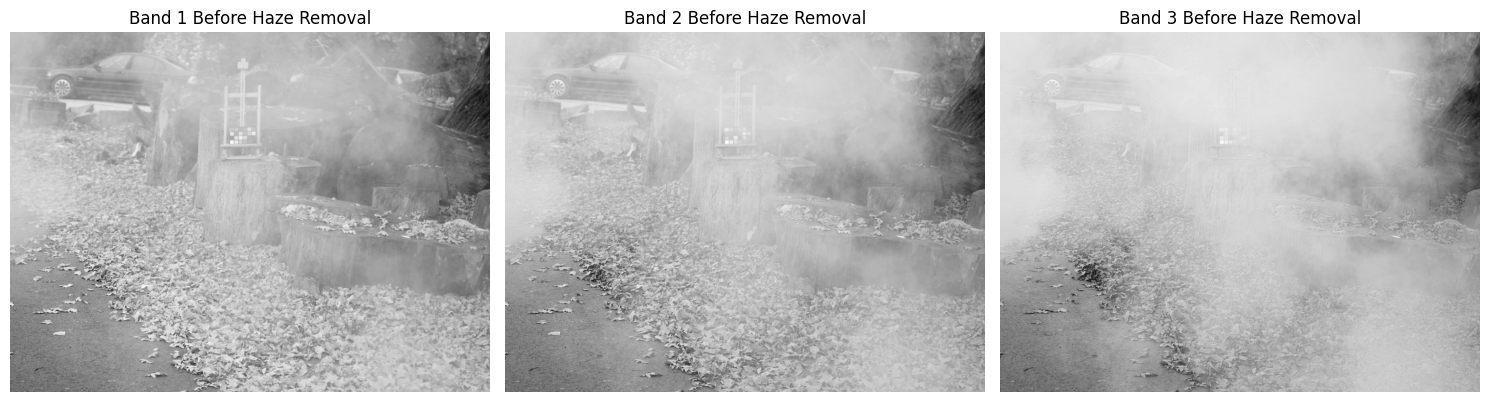

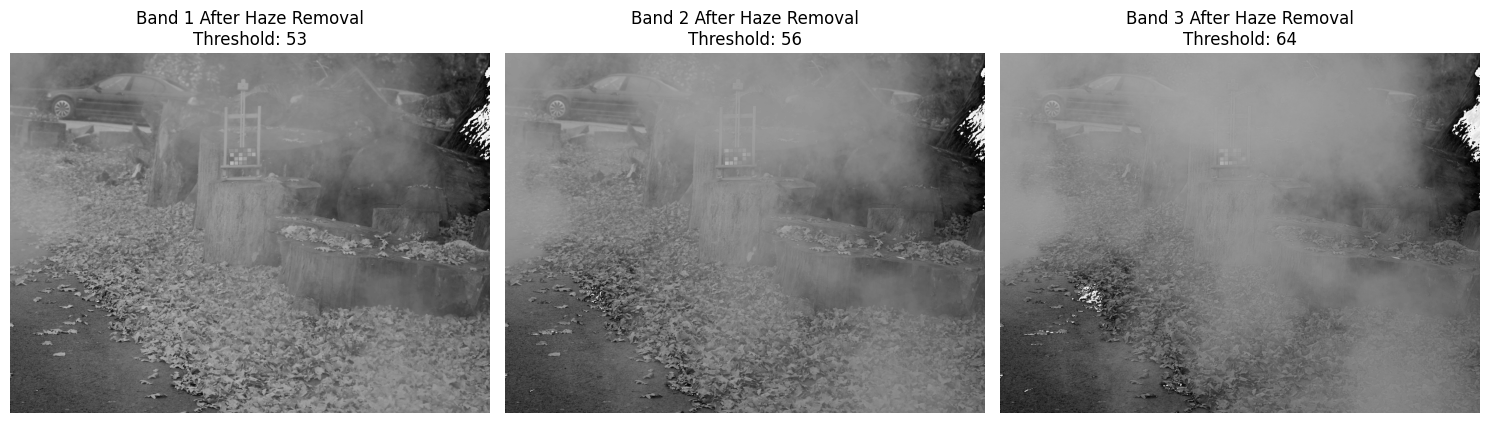

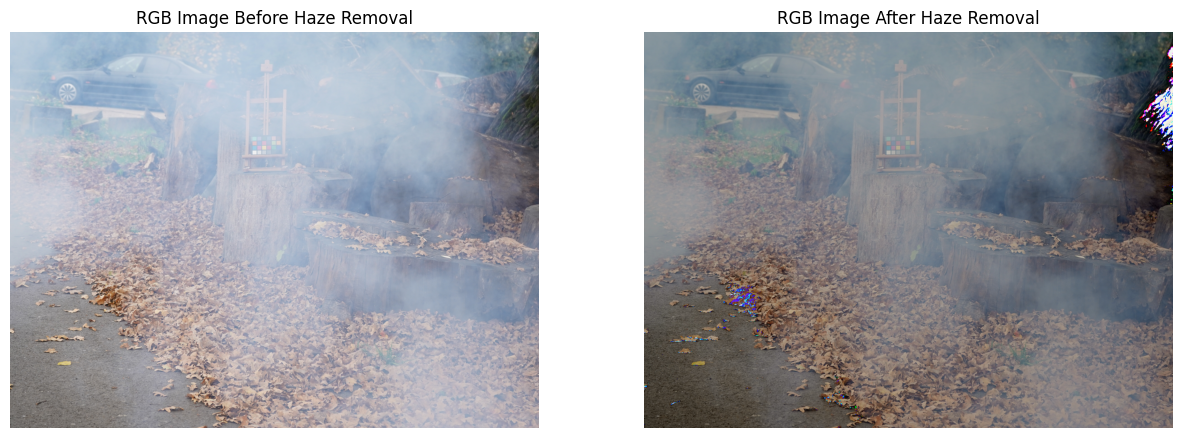

In [24]:
def compute_histogram(image):
	"""
	Function used to compute the histogram of an image

	Args:
		image: The image to compute the histogram of
	"""
	# Compute histogram for the image
	histogram, _ = np.histogram(image.flatten(), bins=256, range=(0, 256))
	return histogram

def compute_subtractive_bias(histogram, threshold):
	"""
	Function used to compute the subtractive bias of a histogram

	Args:
		histogram: The histogram of the image
		threshold: The threshold to use
	"""
	# Compute subtractive bias as the minimum brightness value
	subtractive_bias = np.argmax(histogram > threshold)
	return subtractive_bias

def haze_removal(image, threshold = 500):
    # Compute histograms for each band
	histograms = [compute_histogram(band) for band in image]
	
	# Compute subtractive biases
	subtractive_biases = [compute_subtractive_bias(hist, threshold) for hist in histograms]
	
	# Apply subtractive biases to remove haze
	haze_removed_image = np.array([np.abs(image[i] - subtractive_biases[i]) for i in range(image.shape[0])])
	
	# Shift histograms to the left
	shifted_histograms = [compute_histogram(band) for band in haze_removed_image]
	
	return haze_removed_image, histograms, shifted_histograms, subtractive_biases

def plot_histograms(histograms, shifted_histograms):
	# Display histograms and images before and after haze removal
	plt.figure(figsize=(15, 5))
	# Plot histograms before and after haze removal
	for i in range(len(histograms)):
		plt.subplot(2, len(histograms), i+1)
		plt.plot(histograms[i], label='Before Haze Removal')
		plt.plot(shifted_histograms[i], label='After Histogram Shift')
		plt.title(f'Band {i+1} Histogram')
		plt.xlabel('Brightness')
		plt.ylabel('Frequency')
		plt.legend()
	plt.tight_layout()
	plt.show()

def plot_grey_images(images, haze_removed_image, subtractive_biases):
	# Bands before removal figure
	plt.figure(figsize=(15, 5))
	for i in range(images.shape[0]):
		plt.subplot(1, images.shape[0], i+1)
		plt.imshow(images[i], cmap='gray')
		plt.title(f'Band {i+1} Before Haze Removal')
		plt.axis('off')
	plt.tight_layout()
	plt.show()

	# Bands after removal figure
	plt.figure(figsize=(15, 5))
	for i in range(images.shape[0]):
		plt.subplot(1, images.shape[0], i+1)
		plt.imshow(haze_removed_image[i], cmap='gray')
		plt.title(f'Band {i+1} After Haze Removal\nThreshold: {subtractive_biases[i]}')
		plt.axis('off')
	plt.tight_layout()
	plt.show()

def plot_images(image, haze_removed_image):
	# Display images before and after haze removal
	plt.figure(figsize=(15, 10))

	# Plot RGB image before haze removal
	plt.subplot(1, 2, 1)
	plt.title('RGB Image Before Haze Removal')
	plt.imshow(np.transpose(image, (1, 2, 0))) # to convert from (3, n, m) -> (n, m, 3)
	plt.axis('off')

	# Plot RGB image after haze removal
	plt.subplot(1, 2, 2)
	plt.title('RGB Image After Haze Removal')
	plt.imshow(np.transpose(haze_removed_image, (1, 2, 0))) # to convert from (3, n, m) -> (n, m, 3)
	plt.axis('off')
	plt.show()

# Read the original image
with rasterio.open('haze_img.png') as src:
	images = src.read()  # Read all bands

haze_removed_image, histograms, shifted_histograms, subtractive_biases = haze_removal(images)

plot_histograms(histograms, shifted_histograms)
plot_grey_images(images, haze_removed_image, subtractive_biases)
plot_images(images, haze_removed_image)


## Submission Instructions

To ensure a smooth evaluation process, please follow these steps for submitting your work:

1. **Prepare Your Submission:** Alongside your main notebook, include any additional files that are necessary for running the notebook successfully. This might include data files, images, or supplementary scripts.

2. **Rename Your Files:** Before submission, please rename your notebook to reflect the IDs of the two students working on this project. The format should be `ID1_ID2`, where `ID1` and `ID2` are the student IDs. For example, if the student IDs are `9123456` and `9876543`, then your notebook should be named `9123456_9876543.ipynb`.

3. **Check for Completeness:** Ensure that all required tasks are completed and that the notebook runs from start to finish without errors. This step is crucial for a smooth evaluation.

4. **Submit Your Work:** Once everything is in order, submit your notebook and any additional files via the designated submission link on Google Classroom **(code: 2yj6e24)**. Make sure you meet the submission deadline to avoid any late penalties.
5. Please, note that the same student should submit the assignments for the pair throughout the semester.

By following these instructions carefully, you help us in evaluating your work efficiently and fairly **and any failure to adhere to these guidelines can affect your grades**. If you encounter any difficulties or have questions about the submission process, please reach out as soon as possible.

We look forward to seeing your completed projects and wish you the best of luck!
